In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Statistics by Parameter Combination:
 # of stores  store_lead_time  store_underage_cost  stores_correlation  Architecture Class  Test Loss  train_n_samples  Learning Rate  Train Loss  Dev Loss  Test Gap %  Mean Test Loss  Test Loss Variance
           3                2                    4                 0.0              GNN_MP   3.295232          32768.0         0.0001    3.299220  3.298535    0.000000        3.295232                 NaN
           3                2                    4                 0.0          Vanilla NN   3.300000              NaN            NaN         NaN       NaN    0.144696        3.300000                 NaN
           3                2                    4                 0.0 lower_bound(zipkin)   3.297690              NaN            NaN         NaN       NaN    0.074595        3.297690                 NaN
           5                2                    4                 0.0              GNN_MP   2.937314          32768.0         0.0001    2.937379 

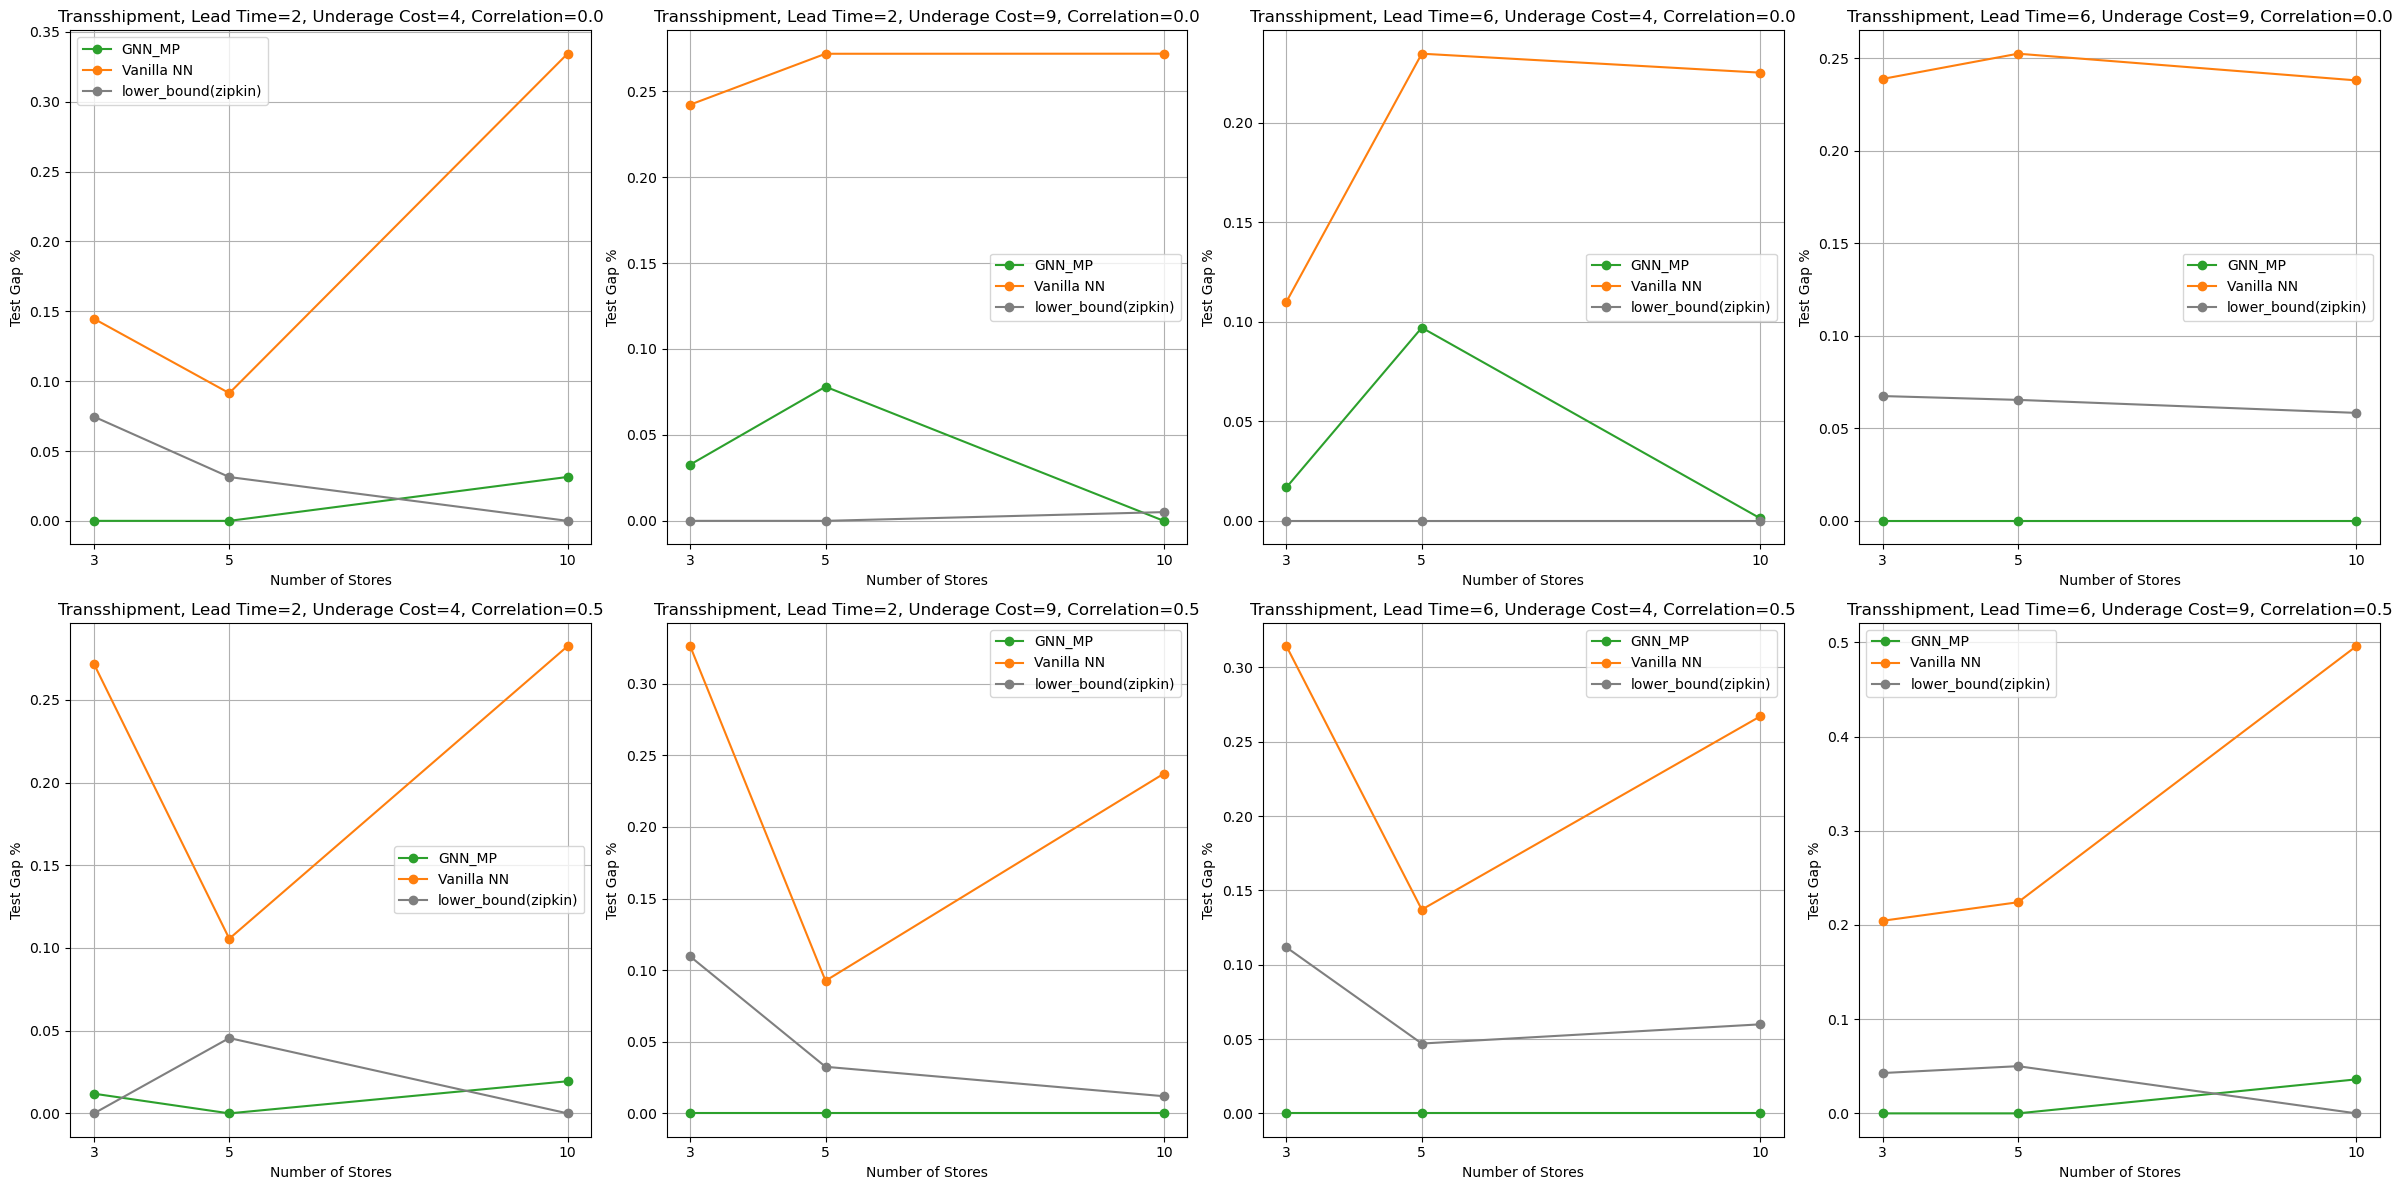

In [3]:
# Create vanilla results dataframe from the provided data
vanilla_data = []
lower_bound_data = []
for n_stores in [3, 5, 10]:
    for lead_time in [2, 6]:
        for underage_cost in [4, 9]:
            for correlation in [0.0, 0.5]:
                # Find matching row in provided data
                vanilla_row = {
                    '# of stores': n_stores,
                    'store_lead_time': lead_time, 
                    'store_underage_cost': underage_cost,
                    'stores_correlation': correlation,
                    'Architecture Class': 'Vanilla NN',
                    'Test Loss': None
                }
                lower_bound_row = {
                    '# of stores': n_stores,
                    'store_lead_time': lead_time,
                    'store_underage_cost': underage_cost, 
                    'stores_correlation': correlation,
                    'Architecture Class': 'lower_bound(zipkin)',
                    'Test Loss': None
                }
                # Match with provided data and set test loss
                if n_stores == 3 and lead_time == 2 and underage_cost == 4 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 3.30
                    lower_bound_row['Test Loss'] = 3.30 * 0.9993 # 0.07% lower
                elif n_stores == 3 and lead_time == 2 and underage_cost == 4 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 3.69
                    lower_bound_row['Test Loss'] = 3.68
                elif n_stores == 3 and lead_time == 2 and underage_cost == 9 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 4.14
                    lower_bound_row['Test Loss'] = 4.13
                elif n_stores == 3 and lead_time == 2 and underage_cost == 9 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 4.63
                    lower_bound_row['Test Loss'] = 4.62
                elif n_stores == 3 and lead_time == 6 and underage_cost == 4 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 4.66
                    lower_bound_row['Test Loss'] = 4.66 * 0.9989 # 0.11% lower
                elif n_stores == 3 and lead_time == 6 and underage_cost == 4 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 4.95
                    lower_bound_row['Test Loss'] = 4.94
                elif n_stores == 3 and lead_time == 6 and underage_cost == 9 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 5.85
                    lower_bound_row['Test Loss'] = 5.84
                elif n_stores == 3 and lead_time == 6 and underage_cost == 9 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 6.20
                    lower_bound_row['Test Loss'] = 6.19
                elif n_stores == 5 and lead_time == 2 and underage_cost == 4 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 2.94
                    lower_bound_row['Test Loss'] = 2.94 * 0.9994 # 0.06% lower
                elif n_stores == 5 and lead_time == 2 and underage_cost == 4 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 3.39
                    lower_bound_row['Test Loss'] = 3.39 * 0.9994 # 0.06% lower
                elif n_stores == 5 and lead_time == 2 and underage_cost == 9 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 3.69
                    lower_bound_row['Test Loss'] = 3.68
                elif n_stores == 5 and lead_time == 2 and underage_cost == 9 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 4.25
                    lower_bound_row['Test Loss'] = 4.25 * 0.9994 # 0.06% lower
                elif n_stores == 5 and lead_time == 6 and underage_cost == 4 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 4.27
                    lower_bound_row['Test Loss'] = 4.26
                elif n_stores == 5 and lead_time == 6 and underage_cost == 4 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 4.59
                    lower_bound_row['Test Loss'] = 4.59 * 0.9991 # 0.09% lower
                elif n_stores == 5 and lead_time == 6 and underage_cost == 9 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 5.36
                    lower_bound_row['Test Loss'] = 5.35
                elif n_stores == 5 and lead_time == 6 and underage_cost == 9 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 5.76
                    lower_bound_row['Test Loss'] = 5.75
                elif n_stores == 10 and lead_time == 2 and underage_cost == 4 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 3.00
                    lower_bound_row['Test Loss'] = 2.99
                elif n_stores == 10 and lead_time == 2 and underage_cost == 4 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 3.55
                    lower_bound_row['Test Loss'] = 3.54
                elif n_stores == 10 and lead_time == 2 and underage_cost == 9 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 3.76
                    lower_bound_row['Test Loss'] = 3.75
                elif n_stores == 10 and lead_time == 2 and underage_cost == 9 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 4.45
                    lower_bound_row['Test Loss'] = 4.44
                elif n_stores == 10 and lead_time == 6 and underage_cost == 4 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 4.45
                    lower_bound_row['Test Loss'] = 4.44
                elif n_stores == 10 and lead_time == 6 and underage_cost == 4 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 4.84
                    lower_bound_row['Test Loss'] = 4.83
                elif n_stores == 10 and lead_time == 6 and underage_cost == 9 and correlation == 0.0:
                    vanilla_row['Test Loss'] = 5.58
                    lower_bound_row['Test Loss'] = 5.57
                elif n_stores == 10 and lead_time == 6 and underage_cost == 9 and correlation == 0.5:
                    vanilla_row['Test Loss'] = 6.08
                    lower_bound_row['Test Loss'] = 6.05
                vanilla_data.append(vanilla_row)
                lower_bound_data.append(lower_bound_row)

vanilla_df = pd.DataFrame(vanilla_data)
lower_bound_df = pd.DataFrame(lower_bound_data)

# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#2ca02c",  # Green
    "lower_bound(zipkin)": "#7f7f7f",  # Gray
    "Vanilla NN": "#ff7f0e",  # Orange
}

linestyle_scheme = {
    "GNN_MP": "-",  # Solid
    "lower_bound(zipkin)": "-", # Solid
    "Vanilla NN": "-",  # Solid
}

testset_name = "generic_architecture_transshipment"
# Define paths for each architecture
architectures = {
    "GNN_MP": {}
}

for arch in architectures:
    architectures[arch] = {
        n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_transshipment/{n_stores}'
        for n_stores in [3, 5, 10]
    }
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
dfs = []
params = {
    'store_lead_time': [2, 6],
    'store_underage_cost': [4, 9], 
    'stores_correlation': [0.0, 0.5]
}
dfs.append(vanilla_df)
dfs.append(lower_bound_df)

for arch_name, paths in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            for correlation in params['stores_correlation']:
                df = results_interpretor.make_table(paths,
                    {'store_lead_time': lead_time,
                     'store_underage_cost': underage_cost,
                     'stores_correlation': correlation,
                     'train_n_samples': [32768]},
                    default_condition_setter, custom_data_filler, 
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
                if df.empty:
                    continue
                
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['store_lead_time'] = lead_time
                df['store_underage_cost'] = underage_cost
                df['stores_correlation'] = correlation
                dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage for each parameter combination
# Calculate min test loss per parameter group
min_test_loss = df.groupby(['# of stores', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100

# Calculate mean and variance statistics grouped by parameters and architecture
grouped_stats = df.groupby(['# of stores', 'Architecture Class', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss']
df['Mean Test Loss'] = grouped_stats.transform('mean').round(6)
df['Test Loss Variance'] = grouped_stats.transform('var').round(6)

# Keep only the row with lowest mean test loss for each setting
df = df.loc[df.groupby(['# of stores', 'Architecture Class', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss'].idxmin()]

# Create subplots for each parameter combination
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

param_combinations = []
# First add all combinations with correlation 0.0
for lt in params['store_lead_time']:
    for uc in params['store_underage_cost']:
        param_combinations.append((lt, uc, 0.0))
# Then add all combinations with correlation 0.5        
for lt in params['store_lead_time']:
    for uc in params['store_underage_cost']:
        param_combinations.append((lt, uc, 0.5))

for idx, (lt, uc, corr) in enumerate(param_combinations):
    data = df[(df['store_lead_time'] == lt) & 
              (df['store_underage_cost'] == uc) &
              (df['stores_correlation'] == corr)]
    
    pivot_df = data.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()
    
    for arch in pivot_df.columns:
        axes[idx].plot(pivot_df.index.to_numpy(), pivot_df[arch].to_numpy(),
                marker='o', label=arch,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch])
    axes[idx].set_title(f'Transshipment, Lead Time={lt}, Underage Cost={uc}, Correlation={corr}')
    axes[idx].set_xlabel('Number of Stores')
    axes[idx].set_ylabel('Test Gap %')
    axes[idx].grid(True)
    axes[idx].legend()
    axes[idx].set_xticks([3, 5, 10])

print("\nStatistics by Parameter Combination:")

# Drop specified columns
df = df.drop(['# of runs', 'hyperparam_name', 'path'], axis=1)

print(df.sort_values(['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores']).to_string(index=False))

plt.tight_layout()
plt.show()

In [4]:
# Calculate average % difference between GNN_MP and Vanilla NN test losses
gnn_data = df[df['Architecture Class'] == 'GNN_MP']
vanilla_data = df[df['Architecture Class'] == 'Vanilla NN'] 
zipkin_data = df[df['Architecture Class'] == 'lower_bound(zipkin)']

# Merge the data to compare GNN vs Vanilla
vanilla_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    vanilla_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores'],
    suffixes=('_gnn', '_vanilla')
)

# Merge the data to compare GNN vs Zipkin
zipkin_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    zipkin_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores'],
    suffixes=('_gnn', '_zipkin')
)

# Calculate % differences
vanilla_comparison['pct_diff'] = ((vanilla_comparison['Test Loss_gnn'] - vanilla_comparison['Test Loss_vanilla']) / vanilla_comparison['Test Loss_vanilla']) * 100
zipkin_comparison['pct_diff'] = ((zipkin_comparison['Test Loss_gnn'] - zipkin_comparison['Test Loss_zipkin']) / zipkin_comparison['Test Loss_zipkin']) * 100

# Calculate and display average % differences
avg_vanilla_diff = vanilla_comparison['pct_diff'].mean()
avg_zipkin_diff = zipkin_comparison['pct_diff'].mean()
print(f"Average % difference between GNN_MP and Vanilla NN test losses: {avg_vanilla_diff:.2f}%")
print(f"Average % difference between GNN_MP and Zipkin lower bound test losses: {avg_zipkin_diff:.2f}%")

# Print detailed comparisons by parameter combination
print("\nDetailed comparison with Vanilla NN by parameter combination:")
for _, row in vanilla_comparison.iterrows():
    print(f"Lead Time: {row['store_lead_time']}, Underage Cost: {row['store_underage_cost']}, " 
          f"Correlation: {row['stores_correlation']}, # Stores: {row['# of stores']}")
    print(f"GNN Loss: {row['Test Loss_gnn']:.2f}, Vanilla Loss: {row['Test Loss_vanilla']:.2f}, "
          f"Difference: {row['pct_diff']:.2f}%\n")

print("\nDetailed comparison with Zipkin lower bound by parameter combination:")
for _, row in zipkin_comparison.iterrows():
    print(f"Lead Time: {row['store_lead_time']}, Underage Cost: {row['store_underage_cost']}, " 
          f"Correlation: {row['stores_correlation']}, # Stores: {row['# of stores']}")
    print(f"GNN Loss: {row['Test Loss_gnn']:.2f}, Zipkin Loss: {row['Test Loss_zipkin']:.2f}, "
          f"Difference: {row['pct_diff']:.2f}%\n")

Average % difference between GNN_MP and Vanilla NN test losses: -0.22%
Average % difference between GNN_MP and Zipkin lower bound test losses: -0.02%

Detailed comparison with Vanilla NN by parameter combination:
Lead Time: 2.0, Underage Cost: 4.0, Correlation: 0.0, # Stores: 3.0
GNN Loss: 3.30, Vanilla Loss: 3.30, Difference: -0.14%

Lead Time: 2.0, Underage Cost: 4.0, Correlation: 0.5, # Stores: 3.0
GNN Loss: 3.68, Vanilla Loss: 3.69, Difference: -0.26%

Lead Time: 2.0, Underage Cost: 9.0, Correlation: 0.0, # Stores: 3.0
GNN Loss: 4.13, Vanilla Loss: 4.14, Difference: -0.21%

Lead Time: 2.0, Underage Cost: 9.0, Correlation: 0.5, # Stores: 3.0
GNN Loss: 4.61, Vanilla Loss: 4.63, Difference: -0.33%

Lead Time: 6.0, Underage Cost: 4.0, Correlation: 0.0, # Stores: 3.0
GNN Loss: 4.66, Vanilla Loss: 4.66, Difference: -0.09%

Lead Time: 6.0, Underage Cost: 4.0, Correlation: 0.5, # Stores: 3.0
GNN Loss: 4.93, Vanilla Loss: 4.95, Difference: -0.31%

Lead Time: 6.0, Underage Cost: 9.0, Correla


Statistics by Parameter Combination:
 # of stores  store_lead_time  store_underage_cost  stores_correlation  Architecture Class  Test Loss  train_n_samples  Learning Rate  Train Loss  Dev Loss  Test Gap %  Mean Test Loss  Test Loss Variance
           3                6                    9                 0.5              GNN_MP   6.417702             16.0         0.0010    6.151067  6.180712    3.678543        6.417702                 NaN
           3                6                    9                 0.5          Vanilla NN   6.901128             16.0         0.0010    6.278907  6.525818   11.488335        6.901128                 NaN
           3                6                    9                 0.5 lower_bound(zipkin)   6.190000              NaN            NaN         NaN       NaN    0.000000        6.190000                 NaN
           5                6                    9                 0.5              GNN_MP   5.849250             16.0         0.0001    5.964902 

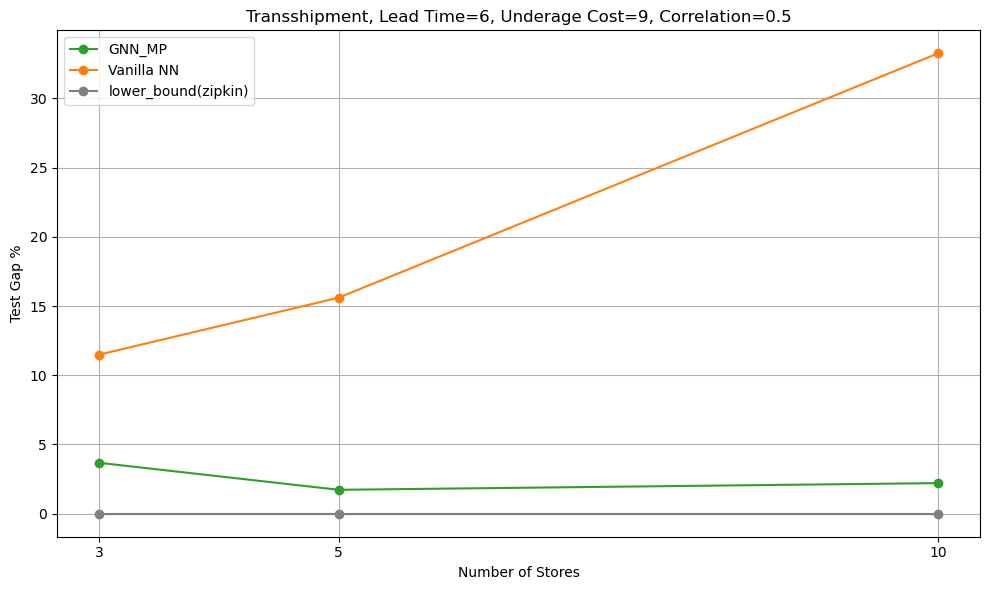

In [7]:
# Create vanilla results dataframe from the provided data
vanilla_data = []
lower_bound_data = []
for n_stores in [3, 5, 10]:
    # Only include lead_time=6, underage_cost=9, correlation=0.5
    lead_time = 6
    underage_cost = 9
    correlation = 0.5
    
    # Find matching row in provided data
    vanilla_row = {
        '# of stores': n_stores,
        'store_lead_time': lead_time, 
        'store_underage_cost': underage_cost,
        'stores_correlation': correlation,
        'Architecture Class': 'Vanilla NN',
        'Test Loss': None
    }
    lower_bound_row = {
        '# of stores': n_stores,
        'store_lead_time': lead_time,
        'store_underage_cost': underage_cost, 
        'stores_correlation': correlation,
        'Architecture Class': 'lower_bound(zipkin)',
        'Test Loss': None
    }
    
    # Match with provided data and set test loss
    if n_stores == 3:
        vanilla_row['Test Loss'] = 6.20
        lower_bound_row['Test Loss'] = 6.19
    elif n_stores == 5:
        vanilla_row['Test Loss'] = 5.76
        lower_bound_row['Test Loss'] = 5.75
    elif n_stores == 10:
        vanilla_row['Test Loss'] = 6.08
        lower_bound_row['Test Loss'] = 6.05

    vanilla_data.append(vanilla_row)
    lower_bound_data.append(lower_bound_row)

vanilla_df = pd.DataFrame(vanilla_data)
lower_bound_df = pd.DataFrame(lower_bound_data)

# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#2ca02c",  # Green
    "GNN_MP_varying": "#1f77b4",  # Blue
    "lower_bound(zipkin)": "#7f7f7f",  # Gray
    "Vanilla NN": "#ff7f0e",  # Orange
}

linestyle_scheme = {
    "GNN_MP": "-",  # Solid
    "GNN_MP_varying": "--",  # Dashed
    "lower_bound(zipkin)": "-", # Solid
    "Vanilla NN": "-",  # Solid
}

testset_name = "generic_architecture_transshipment"

# Define paths for each architecture
architectures = {
    "GNN_MP": {},
    # "GNN_MP_varying": {},
    "Vanilla NN": {}
}

for arch in architectures:
    if arch == "GNN_MP":
        architectures[arch] = {
            n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_transshipment/{n_stores}'
            for n_stores in [3, 5, 10]
        }
    elif arch == "GNN_MP_varying":
        architectures[arch] = {
            n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_transshipment_varying_training_primitives/{n_stores}'
            for n_stores in [3, 5, 10]
        }
    else:  # Vanilla NN
        architectures[arch] = {
            n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment/{n_stores}'
            for n_stores in [3, 5, 10]
        }

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
dfs = []
dfs.append(lower_bound_df)

for arch_name, paths in architectures.items():
    df = results_interpretor.make_table(paths,
        {'store_lead_time': 6,
         'store_underage_cost': 9,
         'stores_correlation': 0.5,
         'train_n_samples': [16]},
        default_condition_setter, custom_data_filler, 
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    if df.empty:
        continue
    
    df.insert(2, 'Architecture Class', arch_name)
    df.insert(1, 'hyperparam_name', arch_name)
    df['store_lead_time'] = 6
    df['store_underage_cost'] = 9
    df['stores_correlation'] = 0.5
    dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage
min_test_loss = df.groupby(['# of stores', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100

# Calculate mean and variance statistics
grouped_stats = df.groupby(['# of stores', 'Architecture Class', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss']
df['Mean Test Loss'] = grouped_stats.transform('mean').round(6)
df['Test Loss Variance'] = grouped_stats.transform('var').round(6)

# Keep only the row with lowest mean test loss for each setting
df = df.loc[df.groupby(['# of stores', 'Architecture Class', 'store_lead_time', 'store_underage_cost', 'stores_correlation'])['Test Loss'].idxmin()]

# Create single plot
plt.figure(figsize=(10, 6))

data = df[(df['store_lead_time'] == 6) & 
          (df['store_underage_cost'] == 9) &
          (df['stores_correlation'] == 0.5)]

pivot_df = data.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()

for arch in pivot_df.columns:
    plt.plot(pivot_df.index.to_numpy(), pivot_df[arch].to_numpy(),
            marker='o', label=arch,
            color=color_scheme[arch],
            linestyle=linestyle_scheme[arch])

plt.title('Transshipment, Lead Time=6, Underage Cost=9, Correlation=0.5')
plt.xlabel('Number of Stores')
plt.ylabel('Test Gap %')
plt.grid(True)
plt.legend()
plt.xticks([3, 5, 10])

print("\nStatistics by Parameter Combination:")

# Drop specified columns
df = df.drop(['# of runs', 'hyperparam_name', 'path'], axis=1)

print(df.sort_values(['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores']).to_string(index=False))

plt.tight_layout()
plt.show()

In [8]:
# Calculate average % difference between GNN_MP and Vanilla NN test losses
gnn_data = df[df['Architecture Class'] == 'GNN_MP']
vanilla_data = df[df['Architecture Class'] == 'Vanilla NN'] 
zipkin_data = df[df['Architecture Class'] == 'lower_bound(zipkin)']

# Merge the data to compare GNN vs Vanilla
vanilla_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    vanilla_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores'],
    suffixes=('_gnn', '_vanilla')
)

# Merge the data to compare GNN vs Zipkin
zipkin_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    zipkin_data[['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost', 'stores_correlation', '# of stores'],
    suffixes=('_gnn', '_zipkin')
)

# Calculate % differences
vanilla_comparison['pct_diff'] = ((vanilla_comparison['Test Loss_gnn'] - vanilla_comparison['Test Loss_vanilla']) / vanilla_comparison['Test Loss_vanilla']) * 100
zipkin_comparison['pct_diff'] = ((zipkin_comparison['Test Loss_gnn'] - zipkin_comparison['Test Loss_zipkin']) / zipkin_comparison['Test Loss_zipkin']) * 100

# Calculate and display average % differences
avg_vanilla_diff = vanilla_comparison['pct_diff'].mean()
avg_zipkin_diff = zipkin_comparison['pct_diff'].mean()
print(f"Average % difference between GNN_MP and Vanilla NN test losses: {avg_vanilla_diff:.2f}%")
print(f"Average % difference between GNN_MP and Zipkin lower bound test losses: {avg_zipkin_diff:.2f}%")

# Print detailed comparisons by parameter combination
print("\nDetailed comparison with Vanilla NN by parameter combination:")
for _, row in vanilla_comparison.iterrows():
    print(f"Lead Time: {row['store_lead_time']}, Underage Cost: {row['store_underage_cost']}, " 
          f"Correlation: {row['stores_correlation']}, # Stores: {row['# of stores']}")
    print(f"GNN Loss: {row['Test Loss_gnn']:.2f}, Vanilla Loss: {row['Test Loss_vanilla']:.2f}, "
          f"Difference: {row['pct_diff']:.2f}%\n")

print("\nDetailed comparison with Zipkin lower bound by parameter combination:")
for _, row in zipkin_comparison.iterrows():
    print(f"Lead Time: {row['store_lead_time']}, Underage Cost: {row['store_underage_cost']}, " 
          f"Correlation: {row['stores_correlation']}, # Stores: {row['# of stores']}")
    print(f"GNN Loss: {row['Test Loss_gnn']:.2f}, Zipkin Loss: {row['Test Loss_zipkin']:.2f}, "
          f"Difference: {row['pct_diff']:.2f}%\n")

Average % difference between GNN_MP and Vanilla NN test losses: -14.10%
Average % difference between GNN_MP and Zipkin lower bound test losses: 2.54%

Detailed comparison with Vanilla NN by parameter combination:
Lead Time: 6.0, Underage Cost: 9.0, Correlation: 0.5, # Stores: 3.0
GNN Loss: 6.42, Vanilla Loss: 6.90, Difference: -7.01%

Lead Time: 6.0, Underage Cost: 9.0, Correlation: 0.5, # Stores: 5.0
GNN Loss: 5.85, Vanilla Loss: 6.65, Difference: -12.01%

Lead Time: 6.0, Underage Cost: 9.0, Correlation: 0.5, # Stores: 10.0
GNN Loss: 6.18, Vanilla Loss: 8.06, Difference: -23.30%


Detailed comparison with Zipkin lower bound by parameter combination:
Lead Time: 6.0, Underage Cost: 9.0, Correlation: 0.5, # Stores: 3.0
GNN Loss: 6.42, Zipkin Loss: 6.19, Difference: 3.68%

Lead Time: 6.0, Underage Cost: 9.0, Correlation: 0.5, # Stores: 5.0
GNN Loss: 5.85, Zipkin Loss: 5.75, Difference: 1.73%

Lead Time: 6.0, Underage Cost: 9.0, Correlation: 0.5, # Stores: 10.0
GNN Loss: 6.18, Zipkin Loss: